In [1]:
# diego
from geoanalysistools.geo import *
today = todayDate()
print(today)

Loading GeoAnalysisTools
27/12/2021


In [2]:
data = readconf("config.toml")

data['IGN']['endDate'] = today
data['IGN']['startDate'] = "01/01/2010"

# intMin= intMax= magMin= magMax= profMin= profMax= cond=
# https://epsg.io/map#srs=4326&x=-17.807&y=28.599&z=10&layer=streets

encoded_data = urllib.parse.urlencode( data['IGN'] , doseq=True)
url = data['default']['search_url'] + encoded_data
# %system explorer "$url"
url

dict_keys(['name', 'default', 'IGN', 'profile1', 'profile2'])


'https://www.ign.es/web/ign/portal/sis-catalogo-terremotos/-/catalogo-terremotos/searchTerremoto?latMin=26.6412193530742&latMax=30.244734978074202&longMin=-19.694437169627594&longMax=-15.212015294627593&startDate=01%2F01%2F2010&endDate=27%2F12%2F2021&selIntensidad=N&selMagnitud=N&selProf=N&fases=no'

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [4]:
# Open a GeoJSON provided and use it as GeoDataFrame
filename = data['default']['global_geojson_file']
df = gpd.read_file(filename, driver="GeoJSON") # The series need minimal processing, next

In [5]:
# Now we're going to budget reduce our GeoDataFrame
# Eliminate empty spaces from columns, rename index, drop unused tables
# and reprocess two columns as DataFrame internally formatted DateTime.
df.drop('tipoMagnitud', axis=1, inplace=True)
df.drop('intensidad', axis=1, inplace=True)

df["Date"] = df["fecha"] + ' ' + df["hora"]
df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
df.drop('hora', axis=1, inplace=True)
df.drop('fecha', axis=1, inplace=True)
df.drop('localizacion', axis=1, inplace=True)
df.set_index('evid', inplace=True)
# df = df.rename(columns={'evid': 'i'})

In [6]:
df.Date.describe()

C:\Users\Diego2\AppData\Local\Temp/ipykernel_1468/3950465283.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


count                   41418
unique                  41313
top       2011-08-23 04:54:29
freq                        3
first     2010-01-02 05:38:34
last      2021-12-27 23:42:33
Name: Date, dtype: object

In [7]:
start_date = "2021-09-01"
end_date = todayDate2()
print(start_date, end_date)
filename = data['default']['global_geojson_slice_file']
saveGeoJsonSlice(df, start_date, end_date, filename)
#df.to_file(filename, driver="GeoJSON")

2021-09-01 2021-12-27


In [8]:
# When all that was fine, we finally can set our bounding box
# and define a timespan for our Series.

# Drop some Rows based on Bounding box condition
df = df.drop(df[df.latitud < data['profile1']['minlat']].index)
df = df.drop(df[df.latitud > data['profile1']['maxlat']].index)
df = df.drop(df[df.longitud < data['profile1']['minlon']].index)
df = df.drop(df[df.longitud > data['profile1']['maxlon']].index)

# Drop some more rows based on DateTime condition.
start_date = "2021-09-01"
end_date = todayDate2()
df = SeriesCutByDate(start_date, end_date, df)

In [9]:
print(df.tail(5))

             latitud  longitud  profundidad  magnitud  \
evid                                                    
es2021zhryi   28.569   -17.866        4.000     1.200   
es2021zhsgq   28.588   -17.901        9.800     1.500   
es2021zhudz   28.557   -17.844       11.400     1.600   
es2021zhuho   28.564   -17.884       18.500     1.500   
es2021zhumv   28.562   -17.857       11.800     1.600   

                               geometry                Date  
evid                                                         
es2021zhryi  POINT (-17.86640 28.56880) 2021-12-26 21:33:27  
es2021zhsgq  POINT (-17.90100 28.58790) 2021-12-26 21:43:05  
es2021zhudz  POINT (-17.84380 28.55740) 2021-12-26 22:40:38  
es2021zhuho  POINT (-17.88390 28.56360) 2021-12-26 22:44:47  
es2021zhumv  POINT (-17.85740 28.56180) 2021-12-26 22:50:56  


In [10]:
# Our GeoDataFrame is completely Ready to work, 
# Let's observe some fundamental rows by their relevance,
df.describe(percentiles=[.05,.10,.20,.25,.30,.40,.45,.50,.60,.70,.75,.80,.90,.95,.97,.98,.99],
    include='all',datetime_is_numeric=True)

C:\venv39\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,latitud,longitud,profundidad,magnitud,geometry,Date
count,7283.000,7283.000,7283.000,7283.000,7283,7283
unique,NaN,NaN,NaN,NaN,7105,NaN
top,NaN,NaN,NaN,NaN,POINT (-17.8344 28.5567),NaN
freq,NaN,NaN,NaN,NaN,3,NaN
mean,28.568,-17.842,14.055,2.618,NaN,2021-10-29 11:28:48.831937280
min,28.477,-17.970,0.000,0.700,NaN,2021-09-09 00:28:58
5%,28.549,-17.889,5.000,1.600,NaN,2021-09-13 03:33:26.600000
10%,28.553,-17.877,8.200,1.800,NaN,2021-09-14 14:12:14.200000
20%,28.557,-17.856,9.800,2.200,NaN,2021-09-19 15:09:18.200000
25%,28.559,-17.850,10.100,2.400,NaN,2021-10-11 11:24:05.500000


In [11]:
# Define some condition for Series
# Replace seism series type with class methods
class FrameAnalysis():
    def __init__(self):
        self.frame = np.ones((3,3))
        self.frame[1,1] = 0
        self.location = np.zeros((3,3))

class RaceDataSeries(object):
    def __init__(self, dataframe, params, depth_key='depth'):
        self.gdf1 = dataframe
        self.seism_params = params
        self.depth_key = depth_key

    def get_all(self):
        series = []
        labels = []
        for seism_type in seism_params:
            frame = self.gdf1.loc[ self.gdf1[self.depth_key].between(self.seism_params[seism_type][0],self.seism_params[seism_type][1]) ]
            series.append(frame)
            mylabel = str( self.seism_params[seism_type][0] ) + '-' + str( self.seism_params[seism_type][1] )
            labels.append(mylabel)
        return series, labels

    def get_one(self, seism_type):
        return self.gdf1.loc[ self.gdf1[self.depth_key].between(self.seism_params[seism_type][0],self.seism_params[seism_type][1]) ]


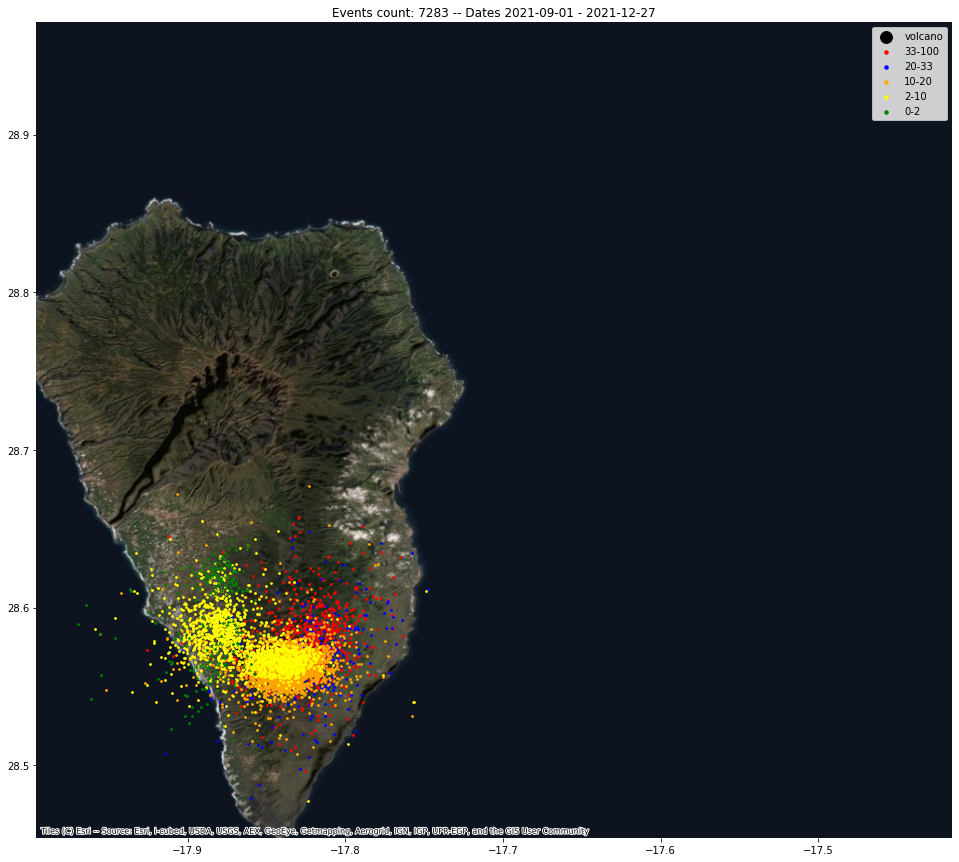

In [12]:
# Finally Plot all series after performing a CRS conversion on GeoDataFrame
# Our source GeoJSON points to a CRS84 (Web Coordinate Projection)
# We convert it to some other.
# Cam 1:La Sagrada Familia (5km) 28.6348°N 17.8894°W
# Cam 2:Roque de los Muchachos OBSY (16km) 28.7541°N 17.8892°W
# Cam 3:Puerto Tazacorte, Ocean Entry (3.7km)
# Volcano (7.9km) 28.6390°N, 17.945°W

fig = plt.figure(figsize=(23, 15))
ax = plt.subplot(111, frameon=False)

# Here we custom define a alternate Items to display on Render
df_alt = pd.DataFrame(
    {'Vents': ['Vent 1', 'Cam3', 'Cam2', 'Cam1'],
     'Name': ['Dolly', 'Cam3', 'Cam2', 'Cam1'],
     'latitud': [28.58, 28.6390, 28.7541, 28.6348],
     'longitud': [-17.84, -17.945, -17.8892, -17.8894]})
df_alt = pd.DataFrame(
    {'Vents': ['Vent 1'],
     'Name': ['Dolly'],
     'latitud': [28.58],
     'longitud': [-17.84]})
volcano = GeoDataFrame(df_alt, geometry=gpd.points_from_xy(df_alt.longitud, df_alt.latitud))
volcano = volcano.set_crs('epsg:4326') # CRS84 is EPSG:4326

def gdfplot(geoseries):
    gdf = []
    for df1 in geoseries:
        gdf1 = GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitud, df1.latitud))
        gdf1 = gdf1.set_crs('epsg:4326') # CRS84 is EPSG:4326
        # gdf1 = gdf1.to_crs(epsg=3857)
        gdf.append(gdf1)        

    volcano.plot( figsize=(16, 7), ax=ax, label='volcano', alpha=1.0, c='black', markersize=35)
    
    n = 0
    for geoframe in gdf:        
        color = plt.cm.Spectral(1/(1+2*np.arange(len(gdf))))
        color = ['red', 'blue','orange','yellow','green','brown','violet','white','tuscany']
        geoframe.plot( figsize=(16, 7), ax=ax, label=labels[n], color=color[n], alpha=1.0, markersize=3)
    
        n +=1

    # Here goes our added coordinates plot,
    epsg = gdf[0].crs.to_string()
    epsg = "epsg:4326"
    ctx.add_basemap(ax, crs=epsg, source=ctx.providers.Esri.WorldImagery)
    return ax

seism_params = {
    'superior': (33,100), 
    'higher': (20,33),
    'high': (10,20),
    'nominal': (2,10),
    'low': (0,2)
    }
    
geoseries, labels = RaceDataSeries(dataframe=df, params=seism_params, depth_key='profundidad').get_all()
ax0 = gdfplot(geoseries)

plt.title("Events count: %s -- Dates %s - %s" % (len(df), start_date, end_date))
plt.legend(loc="upper right", markerscale=2)
plt.show()

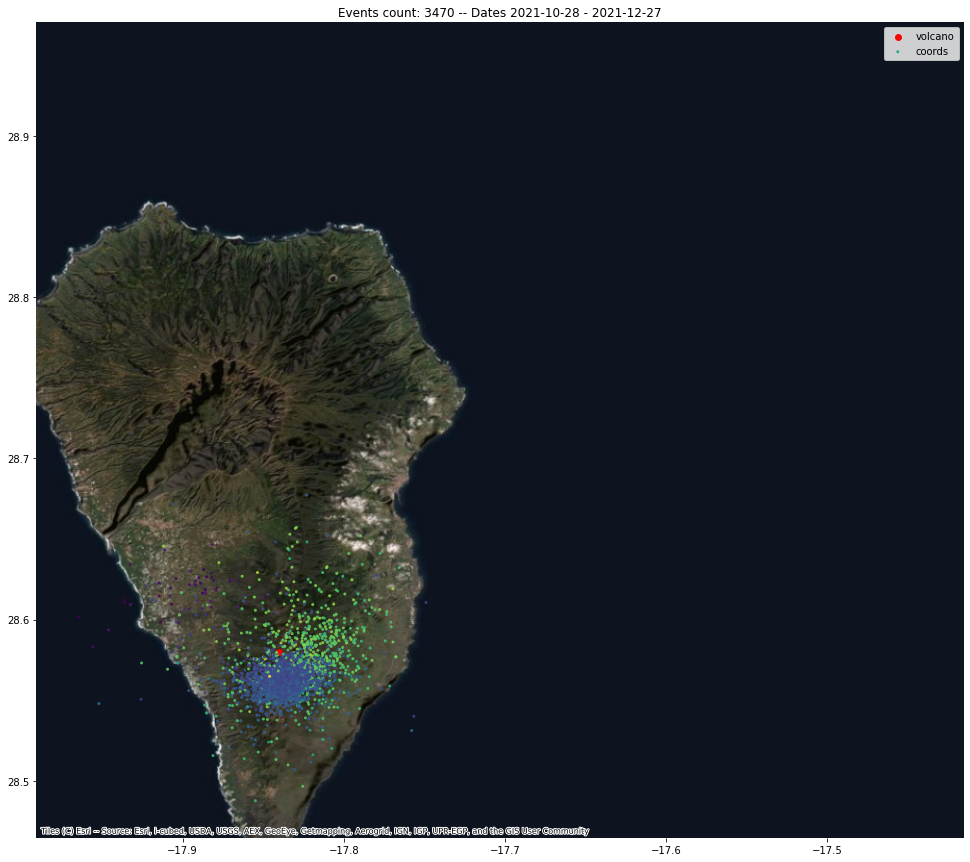

In [13]:
start_date = "2021-10-28"
end_date = todayDate2()
df2 = SeriesCutByDate(start_date, end_date, df)
# _df2 = _df2.groupby(['DateTime']).mean(['magnitud','profundidad'])
# df2 = df2.loc[ df2['profundidad'].between(0,33) ]

fig = plt.figure(figsize=(23, 15))
ax = plt.subplot(111, frameon=False)

def gdfplot(_df1):
    # _df1 = _df2.dissolve(by='profundidad', aggfunc='mean')
    gdf1 = GeoDataFrame(_df1, geometry=gpd.points_from_xy(_df1.longitud, _df1.latitud))        
    gdf1 = gdf1.set_crs('epsg:4326') # CRS84 is EPSG:4326
    volcano.plot( figsize=(16, 7), ax=ax, label='volcano', alpha=1.0, c='red', markersize=35)
    gdf1.plot(figsize=(16, 7), label='coords', ax=ax, alpha=.8, scheme='quantiles', c=gdf1.profundidad, markersize=4)    
    ctx.add_basemap(ax, crs=gdf1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
    return ax

ax0 = gdfplot(df2)

plt.title("Events count: %s -- Dates %s - %s" % (len(df2), start_date, end_date))
plt.legend(loc="upper right")
plt.show()

In [14]:
# Now we're done with the basics, let's go to bed and continue later.
# Later we'll parse a series based on multiple conditions 
# And evaluate GeoDataFrame using some linear algebra,

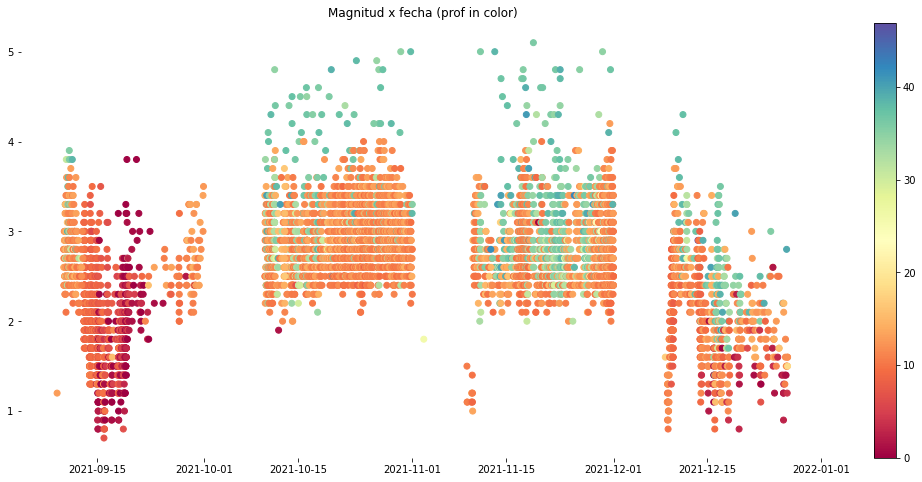

In [15]:
series = []
mag = []
maxdate = 18
def generate_series_by_date(df1):
    for sdate in range(1,maxdate):
        start_date = "2021-10-%s" % sdate
        # end_date = "2021-10-%s" % str(sdate+10)
        end_date = todayDate2()
        SeriesByDate(start_date, end_date, df1)
        y = len(df2)
        series.append(y)
        x = df2.profundidad.mean()
        mag.append(x)
        #print(df.magnitud.values)

start_date = "2017-01-01"
end_date = todayDate2()
df1 = SeriesCutByDate(start_date, end_date, df)

# generate_series_by_date(df1)
fig = plt.figure(figsize=(18, 8))
ax = plt.subplot(111, frameon=False)

mag = nan_to_num(mag, copy=True, nan=0, posinf=None, neginf=None)

color=[]
for m in mag:
    color.append(color_map_color(m))

plt.scatter(df1.Date.values, df1.magnitud.values, c=df1.profundidad, cmap='Spectral')
# plt.scatter(range(1,maxdate), series, c=color,cmap=cmap)
im = plt.gca().get_children()[0]
plt.colorbar(ax=ax)
plt.title("Magnitud x fecha (prof in color)")
plt.show()
df1 = None

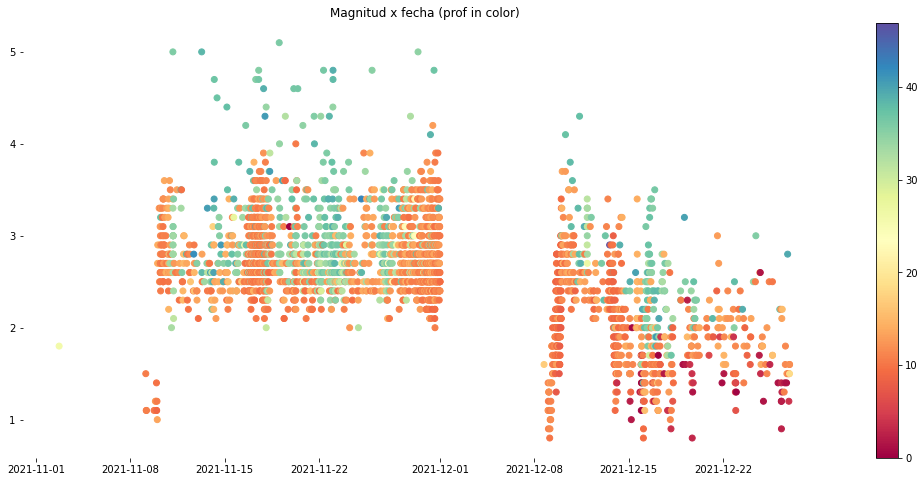

In [21]:
series = []
mag = []
maxdate = 18
def generate_series_by_date(df1):
    for sdate in range(1,maxdate):
        start_date = "2021-10-%s" % sdate
        # end_date = "2021-10-%s" % str(sdate+10)
        end_date = "2021-11-05"
        SeriesByDate(start_date, end_date, df1)
        y = len(df2)
        series.append(y)
        x = df2.profundidad.mean()
        mag.append(x)
        #print(df.magnitud.values)

start_date = "2021-11-01"
end_date = todayDate2()
df1 = SeriesCutByDate(start_date, end_date, df)
#df1.reindex(index=df1.index[::-1])

fig = plt.figure(figsize=(18, 8))
ax = plt.subplot(111, frameon=False)

mag = nan_to_num(mag, copy=True, nan=0, posinf=None, neginf=None)

color=[]
for m in mag:
    color.append(color_map_color(m))

plt.scatter(df1.Date.values, df1.magnitud.values, c=df1.profundidad, cmap='Spectral')
#plt.scatter(df1.magnitud.values,df1.Date.values, c=df1.profundidad, cmap='Spectral')
#plt.scatter(range(1,maxdate), series, c=color,cmap='Spectral')
im = plt.gca().get_children()[0]
plt.colorbar(ax=ax)
plt.title("Magnitud x fecha (prof in color)")
plt.show()
df1 = None

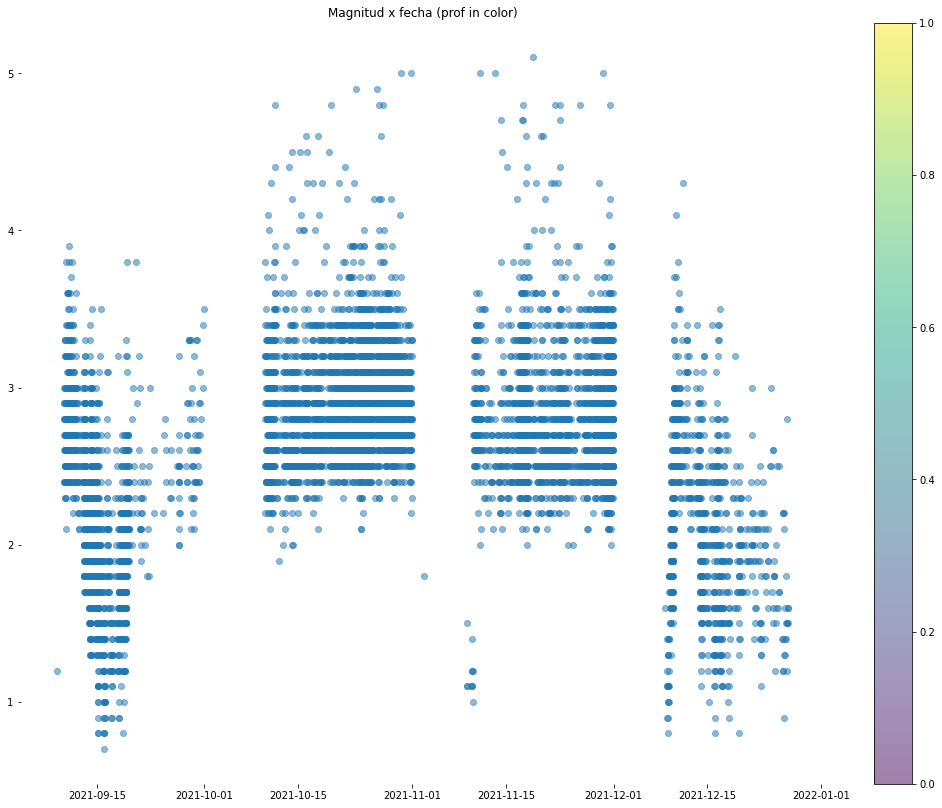

In [22]:
def MySeries():
    for x in range(20,22,2):
        start_date = "20%s-01-01" % x
        end_date = "20%s-01-01" % str(x+2)
        df1 = SeriesCutByDate(start_date, end_date, df)

        fig = plt.figure(figsize=(18, 14))
        ax = plt.subplot(111, frameon=False)

        plt.scatter(df1.Date.values, df1.magnitud.values, alpha=0.5, cmap='Spectral')
        im = plt.gca().get_children()[0]
        plt.colorbar(ax=ax)
        plt.title("Magnitud x fecha (prof in color)")
        plt.show()
        df1 = None
MySeries()

In [23]:
import mapclassify as mc

start_date = "2021-10-14"
end_date = "2021-10-23"
df1 = SeriesCutByDate(start_date, end_date, df)
m = mc.MaximumBreaks(df1.magnitud, k=6)
p1 = mc.MaximumBreaks(df1.profundidad, k=12)

start_date = "2021-10-23"
end_date = "2021-10-31"
df1 = SeriesCutByDate(start_date, end_date, df)
m = mc.MaximumBreaks(df1.magnitud, k=6)
p2 = mc.MaximumBreaks(df1.profundidad, k=12)

start_date = "2021-11-07"
end_date = "2021-11-17"
df1 = SeriesCutByDate(start_date, end_date, df)
p3 = mc.MaximumBreaks(df1.profundidad, k=12)

start_date = "2021-11-17"
end_date = "2021-11-28"
df1 = SeriesCutByDate(start_date, end_date, df)
p4 = mc.MaximumBreaks(df1.profundidad, k=12)

start_date = "2021-11-28"
end_date = "2021-12-12"
df1 = SeriesCutByDate(start_date, end_date, df)
p5 = mc.MaximumBreaks(df1.profundidad, k=24)

start_date = "2021-12-08"
end_date = "2021-12-22"
df1 = SeriesCutByDate(start_date, end_date, df)
p6 = mc.MaximumBreaks(df1.profundidad, k=24)

start_date = "2021-12-2"
end_date = "2021-12-28"
df1 = SeriesCutByDate(start_date, end_date, df)
p7 = mc.MaximumBreaks(df1.profundidad, k=24)

print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
print(p6)
print(p7)

MaximumBreaks         

   Interval      Count
----------------------
[ 3.30,  5.10] |     1
( 5.10,  7.30] |     1
( 7.30,  8.15] |     1
( 8.15, 15.80] |   787
(15.80, 16.80] |     1
(16.80, 19.25] |     1
(19.25, 24.25] |     1
(24.25, 28.65] |     2
(28.65, 31.15] |     8
(31.15, 39.75] |   115
(39.75, 41.30] |     1
(41.30, 42.20] |     1
MaximumBreaks         

   Interval      Count
----------------------
[ 7.80,  8.00] |     2
( 8.00, 17.35] |  1329
(17.35, 19.35] |     1
(19.35, 21.35] |     1
(21.35, 23.30] |     1
(23.30, 25.75] |     1
(25.75, 28.30] |     2
(28.30, 29.50] |     1
(29.50, 30.95] |     2
(30.95, 38.40] |    71
(38.40, 39.00] |     1
(39.00, 39.30] |     1
MaximumBreaks         

   Interval      Count
----------------------
[ 8.90, 16.00] |   228
(16.00, 16.90] |     2
(16.90, 21.60] |     1
(21.60, 26.60] |     1
(26.60, 29.15] |     1
(29.15, 31.60] |     7
(31.60, 32.20] |     1
(32.20, 34.80] |    33
(34.80, 37.85] |    35
(37.85, 39.50] |    10
(39.50, 

dict_keys(['name', 'default', 'IGN', 'profile1', 'profile2'])


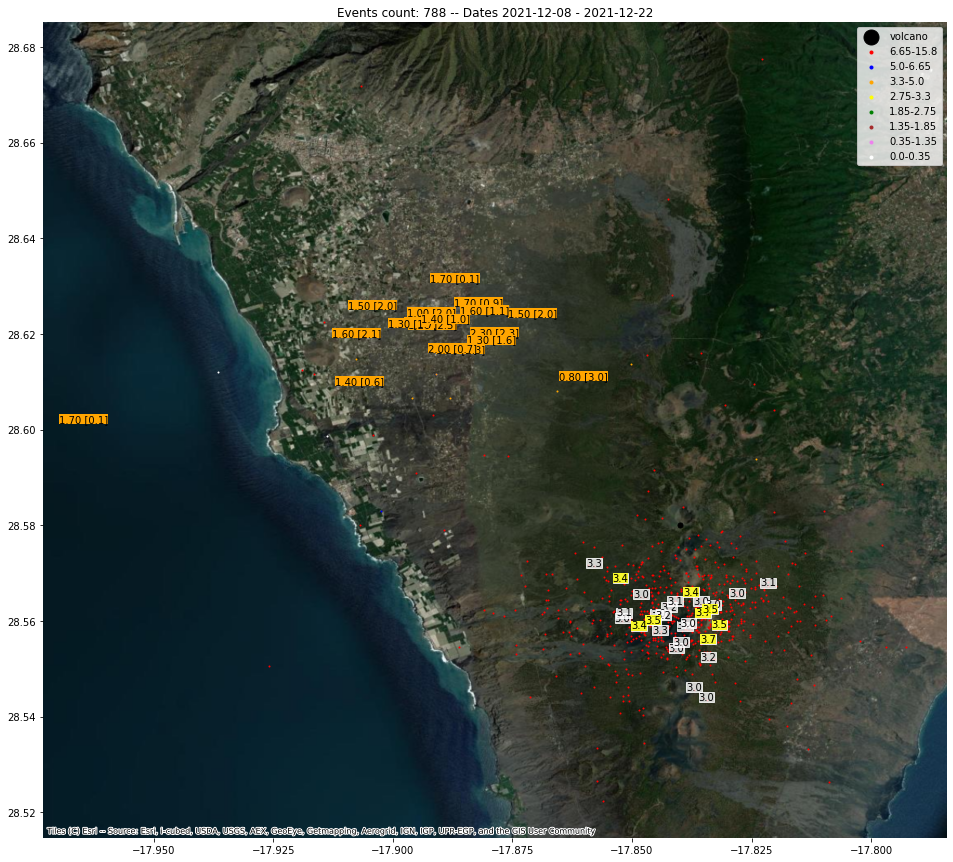

In [24]:
fig = plt.figure(figsize=(23, 15))
ax = plt.subplot(111, frameon=False)

def gdfplot(geoseries):
    gdf = []
    for _df1 in geoseries:
        gdf1 = GeoDataFrame(_df1, geometry=gpd.points_from_xy(_df1.longitud, _df1.latitud))
        gdf1 = gdf1.set_crs('epsg:4326') # CRS84 is EPSG:4326
        # gdf1 = gdf1.to_crs(epsg=3857)
        gdf.append(gdf1)        
    volcano.plot( figsize=(16, 7), ax=ax, label='volcano', alpha=1.0, c='black', markersize=25)   
    n = 0
    for geoframe in gdf:        
        #color = plt.cm.Spectral(1/(1+2*np.arange(len(gdf))))
        color = ['red', 'blue','orange','yellow','green','brown','violet','white','tuscany']
        viridis = cm.get_cmap('viridis', 12)        
        geoframe.plot( figsize=(16, 7), ax=ax, label=labels[n], color=color[n], alpha=1.0, markersize=1)
        n +=1
            
        X = geoframe.loc[ geoframe['profundidad'].between(.1,3.0) ]
        for idx, row in X.iterrows():
            mag = row['magnitud']
            prof = row['profundidad']
            label = "{:.2f} [{:.1f}]".format(mag,prof)
            xy = row['geometry']
            ax.annotate(text=label, xy=(xy.x, xy.y), ha='center', bbox={'facecolor': 'orange', 'alpha':1.0, 'pad': 0, 'edgecolor':'none'})

        X = geoframe.loc[ geoframe['magnitud'].between(2.95,3.8) ]
        for idx, row in X.iterrows():
            mag = row['magnitud']
            label = "{:.1f}".format(mag)
            xy = row['geometry']
            ax.annotate(text=label, xy=(xy.x, xy.y), ha='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 0, 'edgecolor':'white'})
            
        X = geoframe.loc[ geoframe['magnitud'].between(3.4,5.5) ]
        for idx, row in X.iterrows():
            mag = row['magnitud']
            label = "{:.1f}".format(mag)
            xy = row['geometry']
            ax.annotate(text=label, xy=(xy.x, xy.y), ha='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 0, 'edgecolor':'none'})
            
    #    for x,y in zip(X.longitud,X.latitud):
    #        label = "{:.2f}".format(y)

    # Here goes our added coordinates plot,
    #label = gdf[0].crs.to_string()
    label = "epsg:4326"
    ctx.add_basemap(ax, crs=label, source=ctx.providers.Esri.WorldImagery)            
    return ax

data = readconf("config.toml")
# Drop some Rows based on Bounding box condition
df2 = df.drop(df[df.latitud > data['profile2']['minlat']].index)
df2 = df.drop(df[df.latitud < data['profile2']['maxlat']].index)
df2 = df.drop(df[df.longitud < data['profile2']['minlon']].index)
df2 = df.drop(df[df.longitud > data['profile2']['maxlon']].index)

start_date = "2021-12-08"
end_date = "2021-12-22"
df1 = SeriesCutByDate(start_date, end_date, df2)

seism_params = {
    'superior': ( 6.65, 15.80), 
    'higher': ( 5.00,  6.65),
    'high': ( 3.30,  5.00),
    'nominal': ( 2.75,  3.30),
    'low': ( 1.85,  2.75),
    'midlow': ( 1.35,  1.85),
    'verylow': ( 0.35,  1.35),
    'surface': ( 0.00,  0.35)
    }
 
geoseries, labels = RaceDataSeries(dataframe=df1, params=seism_params, depth_key='profundidad').get_all()
ax0 = gdfplot(geoseries)

plt.title("Events count: %s -- Dates %s - %s" % (len(df1), start_date, end_date))
plt.legend(loc="upper right", markerscale=3)
plt.show()
# q_none = gdf.loc[ df['magnitud'].between(1.8,2.4) ]

In [ ]:
# tripled (past week vs this)
( 9.05, 15.65] |   209
+ ( 8.80, 15.45] |   587

# nearly tripled
(29.15, 31.60] |     7
+ (30.45, 31.50] |    18

# from n to 1 (past week)
(32.20, 33.00] |     7
(33.00, 33.85] |    14
(33.85, 34.80] |    12
(34.80, 35.50] |    11

# from 2 to n (this week). 
+ (38.00, 40.20] |   363

In [ ]:
df_orig = df.copy()
df_orig = df.loc[ df['profundidad'].between(0,33) ]
df_orig = df.loc[ df['magnitud'].between(2,6) ]
MySeries()

In [ ]:
pd.Series(['3/11/2000', '3/12/2000', '3/13/2000']*10000)